# Book Data Linkage Statistics

This notebook presents statistics of the book data integration.

## Setup

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

## Load Link Stats

We compute dataset linking statitsics as `gender-stats.csv` using DataFusion.  Let's load those:

In [2]:
link_stats = pd.read_csv('book-links/gender-stats.csv')
link_stats.head()

,dataset,gender,n_books,n_actions
0,BX-E,ambiguous,6770,76143
1,BX-E,no-author-rec,5969,7385
2,BX-I,female,42418,112621
3,BX-I,ambiguous,11061,131270
4,BX-E,female,20997,36047


Now let's define variables for our variou codes. We are first going to define our gender codes.  We'll start with the resolved codes:

In [3]:
link_codes = ['female', 'male', 'ambiguous', 'unknown']

We want the unlink codes in order, so the last is the first link failure:

In [4]:
unlink_codes = ['no-author-rec', 'no-book-author', 'no-book']

In [5]:
all_codes = link_codes + unlink_codes

## Processing Statistics

Now we'll pivot each of our count columns into a table for easier reference.

In [6]:
book_counts = link_stats.pivot('dataset', 'gender', 'n_books')
book_counts = book_counts.reindex(columns=all_codes)
book_counts.assign(total=book_counts.sum(axis=1))

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book,total
dataset,,,,,,,,
AZ,135207.0,366302.0,27392.0,191859.0,129374.0,169361.0,936346.0,1955841.0
BX-E,20997.0,33882.0,6770.0,12496.0,5969.0,6417.0,21884.0,108415.0
BX-I,42418.0,65730.0,11061.0,27261.0,12336.0,12515.0,44070.0,215391.0
GR-E,50014.0,86857.0,21380.0,26113.0,7365.0,743790.0,NaN,935519.0
GR-I,50438.0,87571.0,21419.0,26412.0,7421.0,755665.0,NaN,948926.0
LOC-MDS,575656.0,2074053.0,65294.0,1165940.0,268369.0,834905.0,NaN,4984217.0


In [7]:
act_counts = link_stats.pivot('dataset', 'gender', 'n_actions')
act_counts = act_counts.reindex(columns=all_codes)
act_counts.drop(index='LOC-MDS', inplace=True)
act_counts

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
dataset,,,,,,,
AZ,1253258.0,2592365.0,4916201.0,1094370.0,570516.0,2884603.0,4510138.0
BX-E,36047.0,51435.0,76143.0,16319.0,7385.0,9735.0,25502.0
BX-I,112621.0,137188.0,131270.0,47342.0,19450.0,25536.0,62488.0
GR-E,2188569.0,3791657.0,4222759.0,851866.0,270843.0,11818780.0,NaN
GR-I,5983873.0,10186291.0,9655476.0,2345498.0,725674.0,31397384.0,NaN


We're going to want to compute versions of this table as fractions, e.g. the fraction of books that are written by women.  We will use the following helper function:

In [8]:
def fractionalize(data, columns, unlinked=None):
    fracs = data[columns]
    fracs.columns = fracs.columns.astype('str')
    if unlinked:
        fracs = fracs.assign(unlinked=data[unlinked].sum(axis=1))
    totals = fracs.sum(axis=1)
    return fracs.divide(totals, axis=0)

And a helper function for plotting bar charts:

In [9]:
def plot_bars(fracs, ax=None, cmap=mpl.cm.Dark2):
    if ax is None:
        ax = plt.gca()
    size = 0.5
    ind = np.arange(len(fracs))
    start = pd.Series(0, index=fracs.index)
    for i, col in enumerate(fracs.columns):
        vals = fracs.iloc[:, i]
        rects = ax.barh(ind, vals, size, left=start, label=col, color=cmap(i))
        for j, rec in enumerate(rects):
            if vals.iloc[j] < 0.1 or np.isnan(vals.iloc[j]): continue
            y = rec.get_y() + rec.get_height() / 2
            x = start.iloc[j] + vals.iloc[j] / 2
            ax.annotate('{:.1f}%'.format(vals.iloc[j] * 100),
                        xy=(x,y), ha='center', va='center', color='white',
                        fontweight='bold')
        start += vals.fillna(0)
    ax.set_xlabel('Fraction of Books')
    ax.set_ylabel('Data Set')
    ax.set_yticks(ind)
    ax.set_yticklabels(fracs.index)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Resolution of Books

What fraction of *unique books* are resolved from each source?

In [10]:
fractionalize(book_counts, link_codes + unlink_codes)

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
dataset,,,,,,,
AZ,0.069130,0.187286,0.014005,0.098095,0.066148,0.086592,0.478743
BX-E,0.193672,0.312521,0.062445,0.115261,0.055057,0.059189,0.201854
BX-I,0.196935,0.305166,0.051353,0.126565,0.057273,0.058104,0.204605
GR-E,0.053461,0.092844,0.022854,0.027913,0.007873,0.795056,NaN
GR-I,0.053153,0.092284,0.022572,0.027834,0.007820,0.796337,NaN
LOC-MDS,0.115496,0.416124,0.013100,0.233926,0.053844,0.167510,NaN


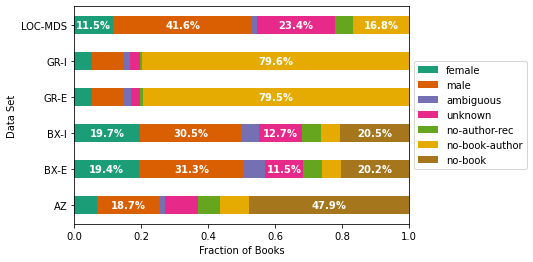

In [11]:
plot_bars(fractionalize(book_counts, link_codes + unlink_codes))

In [12]:
fractionalize(book_counts, link_codes, unlink_codes)

gender,female,male,ambiguous,unknown,unlinked
dataset,,,,,
AZ,0.069130,0.187286,0.014005,0.098095,0.631483
BX-E,0.193672,0.312521,0.062445,0.115261,0.316100
BX-I,0.196935,0.305166,0.051353,0.126565,0.319981
GR-E,0.053461,0.092844,0.022854,0.027913,0.802929
GR-I,0.053153,0.092284,0.022572,0.027834,0.804158
LOC-MDS,0.115496,0.416124,0.013100,0.233926,0.221354


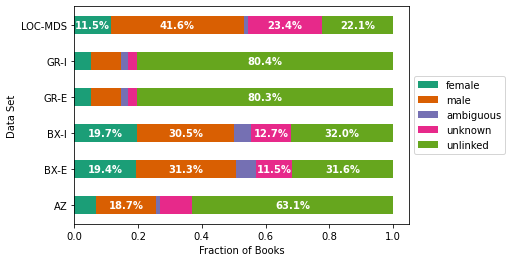

In [13]:
plot_bars(fractionalize(book_counts, link_codes, unlink_codes))

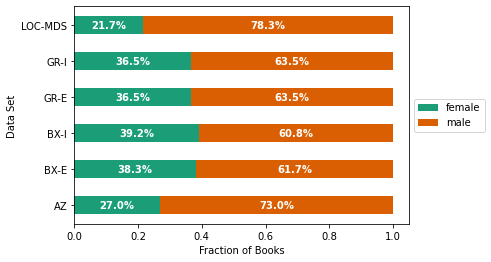

In [14]:
plot_bars(fractionalize(book_counts, ['female', 'male']))

## Resolution of Ratings

What fraction of *rating actions* have each resolution result?

In [15]:
fractionalize(act_counts, link_codes + unlink_codes)

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
dataset,,,,,,,
AZ,0.070323,0.145463,0.275859,0.061407,0.032013,0.161861,0.253074
BX-E,0.161961,0.231100,0.342114,0.073322,0.033181,0.043740,0.114582
BX-I,0.210155,0.255998,0.244955,0.088342,0.036294,0.047651,0.116605
GR-E,0.094561,0.163826,0.182452,0.036806,0.011702,0.510652,NaN
GR-I,0.099245,0.168943,0.160139,0.038901,0.012036,0.520736,NaN


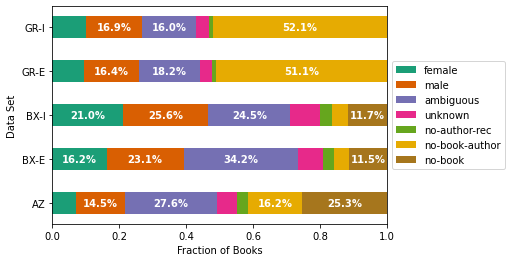

In [16]:
plot_bars(fractionalize(act_counts, link_codes + unlink_codes))

In [17]:
fractionalize(act_counts, link_codes, unlink_codes)

gender,female,male,ambiguous,unknown,unlinked
dataset,,,,,
AZ,0.070323,0.145463,0.275859,0.061407,0.446948
BX-E,0.161961,0.231100,0.342114,0.073322,0.191503
BX-I,0.210155,0.255998,0.244955,0.088342,0.200550
GR-E,0.094561,0.163826,0.182452,0.036806,0.522355
GR-I,0.099245,0.168943,0.160139,0.038901,0.532772


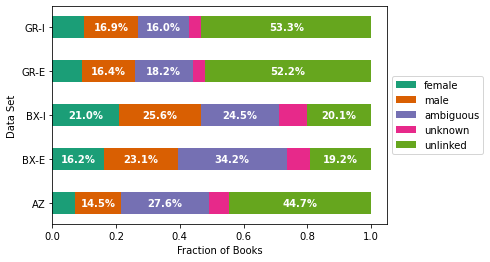

In [18]:
plot_bars(fractionalize(act_counts, link_codes, unlink_codes))

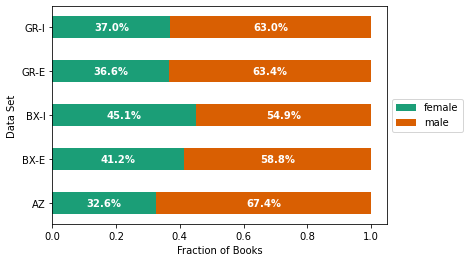

In [19]:
plot_bars(fractionalize(act_counts, ['female', 'male']))